<a href="https://colab.research.google.com/github/Sarraalii/Machine-Learning-Proj/blob/main/Autism%20Project/Machine-Learning-Proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install category_encoders


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 1.3 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
from sklearn.metrics import classification_report, confusion_matrix
# from sklearn.preprocessing import TargetEncoder
from category_encoders import TargetEncoder
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import StandardScaler
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import RocCurveDisplay, auc, roc_curve

warnings.filterwarnings('ignore')

In [8]:
# Load data
data = pd.read_csv('autism.csv')

# Inspect the first three rows of the data
data.head(3)

,ID,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,...,gender,ethnicity,jaundice,autism,country_of_res,used_app_before,result,age_desc,relation,Class/ASD
0,1,1,0,1,0,1,0,1,0,1,...,f,?,no,no,Austria,no,6.351166,18 and more,Self,0
1,2,0,0,0,0,0,0,0,0,0,...,m,?,no,no,India,no,2.255185,18 and more,Self,0
2,3,1,1,1,1,1,1,1,1,1,...,m,White-European,no,yes,United States,no,14.851484,18 and more,Self,1


In [9]:
# Print the dimension of the dataset, DataFrame 'data' with 800 rows and 22 columns
print(data.shape)

(800, 22)


In [10]:
# Count the number of missing values (NaN or None) in each column of the 'data' DataFrame
missing_value_counts = data.isnull().sum()
missing_value_counts

ID                 0
A1_Score           0
A2_Score           0
A3_Score           0
A4_Score           0
A5_Score           0
A6_Score           0
A7_Score           0
A8_Score           0
A9_Score           0
A10_Score          0
age                0
gender             0
ethnicity          0
jaundice           0
autism             0
country_of_res     0
used_app_before    0
result             0
age_desc           0
relation           0
Class/ASD          0
dtype: int64

In [11]:
# Check for missing values represented by '?' in the 'ethnicity' column
missing_ethnicities = data['ethnicity'].unique()
missing_ethnicities

array(['?', 'White-European', 'Middle Eastern ', 'Pasifika', 'Black',
       'Others', 'Hispanic', 'Asian', 'Turkish', 'South Asian', 'Latino',
       'others'], dtype=object)

In [12]:
data['age_desc'].unique()

array(['18 and more'], dtype=object)

In [13]:
data['relation'].unique()

array(['Self', 'Relative', 'Parent', '?', 'Others',
       'Health care professional'], dtype=object)

In [14]:
# Replace '?' symbol with NaN in the 'ethnicity' and 'relation' columns
data['ethnicity'].replace({'?' : np.nan}, inplace=True)
data['relation'].replace({'?' : np.nan}, inplace=True)
# We have 2 others class lower case and upper case we just merge them
data['ethnicity'].replace({ 'others' : 'Others'}, inplace=True)

# Replace categorical values with numerical equivalents
data['jaundice'].replace({'yes' : 1, 'no' : 0}, inplace=True)
data['autism'].replace({'yes' : 1, 'no' : 0}, inplace=True)
data['used_app_before'].replace({'yes' : 1, 'no' : 0}, inplace=True)

# Drop 'ID' and 'age_desc' columns as they are not informative
data.drop(['ID', 'age_desc'], axis=1, inplace=True)

# Convert the 'Class/ASD' column to integer type
data['Class/ASD'] = data['Class/ASD'].astype(int)

In [15]:
# Calculate the percentage of rows with one or more missing values
percentage_missing_rows = (data.isnull().sum(axis=1) > 0).sum() / len(data)
percentage_missing_rows

# If we decide to drop all rows with one or more missing values, we would lose 30% of our data

0.295

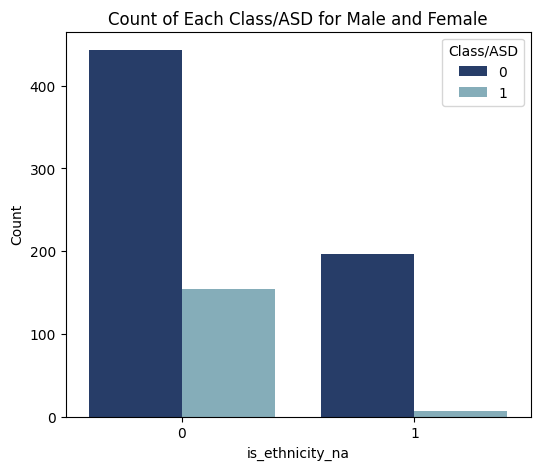

is_ethnicity_na
0    597
1    203
Name: Class/ASD, dtype: int64


In [16]:
# Create a binary indicator column 'is_ethnicity_na' to represent missing values in the 'ethnicity' column
data['is_ethnicity_na'] = data['ethnicity'].isna().astype(int)

# Convert the 'Class/ASD' column to string data type
data['Class/ASD'] = data['Class/ASD'].astype(str)

# Define a list of colors for the countplot
colors = ['#1c3a73', '#7cb1c2']

# Create a grouped bar chart using seaborn's countplot function with specified colors
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='is_ethnicity_na', hue='Class/ASD', palette=colors)

# Set labels and title for the plot
plt.xlabel('is_ethnicity_na')
plt.ylabel('Count')
plt.title('Count of Each Class/ASD for Male and Female')
plt.legend(title='Class/ASD')
plt.show()

# Convert the 'Class/ASD' column back to integer data type
data['Class/ASD'] = data['Class/ASD'].astype(int)

# Calculate the mean of 'Class/ASD' grouped by 'is_ethnicity_na' and print the result
print(data.groupby('is_ethnicity_na')['Class/ASD'].count())

# Remove the 'is_ethnicity_na' column from the DataFrame
data.drop('is_ethnicity_na', axis=1, inplace=True)


In [17]:
# Address class imbalance with `Plotly` pie charts for clear visualization. (Model bias prioritizing majority class)

import plotly.express as px
import pandas as pd


counts = data['Class/ASD'].value_counts()

# Define your color sequence
colors = ['#1c3a73', '#7cb1c2']

fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # size of the hole, 0.5 means 50%
    title='Distribution of Classes in "Class/ASD"',
    color_discrete_sequence=colors  # apply your colors here
)

# Update layout for better appearance
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),  # Adjust top margin to make room for title
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='Class/ASD'
    ),
    title=dict(
        text='Distribution of Classes in "Class/ASD"',
        x=0.45,  # Centering the title
        xanchor='center',
        y=0.95,  # Adjusting y position to place title above chart
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

fig.show()
#An 80-20 split suggests that there is a class imbalance in the dataset, with one class representing 80% of the data and the other only 20%.

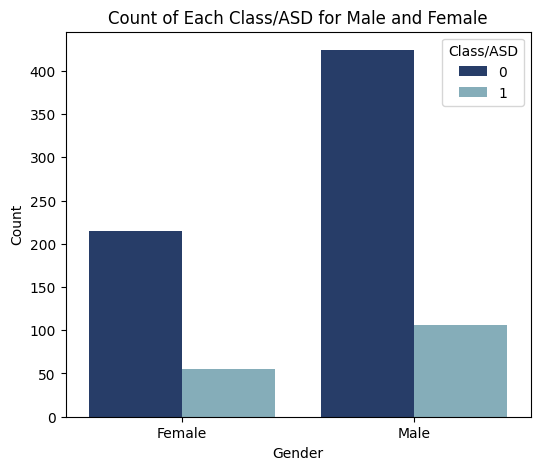

In [18]:
#create a grouped bar chart for visualizing the count of different classes of a variable (Class/ASD) based on gender (Male and Female) in our dataset.
# first replace 'f' with 'Female' and 'm' with 'Male' in the 'gender' column of the DataFrame to add more context to our chart.

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


# Replace 'f' with 'Female' and 'm' with 'Male' in the 'gender' column
data['gender'] = data['gender'].replace({'f': 'Female', 'm': 'Male'})

# Convert the 'Class/ASD' column to string type, not necessary
data['Class/ASD'] = data['Class/ASD'].astype(str)

# Define a list of colors
colors = ['#1c3a73', '#7cb1c2']

# Create the grouped bar chart using seaborn's countplot function with specified colors
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x='gender', hue='Class/ASD', palette=colors)

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Count of Each Class/ASD for Male and Female')
plt.legend(title='Class/ASD')
plt.show()

In [19]:
print('Oldest individual in the dataset was of:', data['age'].max(), 'Years')
print('Youngest individual in the dataset was of:', data['age'].min(), 'Years')
print('Average age in the dataset:', data['age'].mean(), 'Years')

Oldest individual in the dataset was of: 89.4617183 Years
Youngest individual in the dataset was of: 2.718549681 Years
Average age in the dataset: 28.452117626575 Years


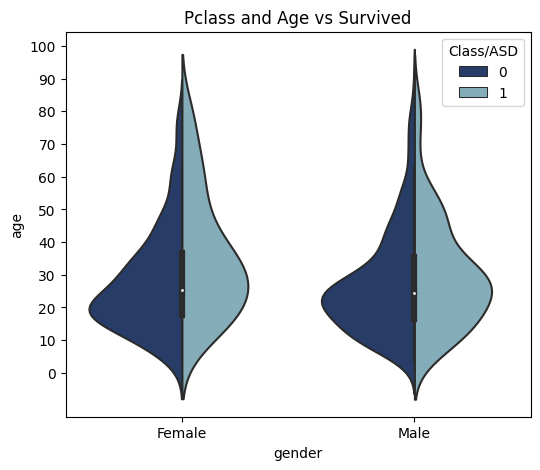

In [20]:
plt.figure(figsize=(6, 5))
sns.violinplot(x="gender", y="age", hue="Class/ASD", data=data, split=True, palette=['#1c3a73', '#7cb1c2'])
plt.title('Pclass and Age vs Survived')
plt.yticks(range(0, 110, 10))
plt.show()

In [21]:
# Display unique values in 'country_of_res' column, to handle high cardinality which will increase dimentionality and make the model complex
print(data['country_of_res'].unique())

['Austria' 'India' 'United States' 'South Africa' 'Jordan'
 'United Kingdom' 'Brazil' 'New Zealand' 'Canada' 'Kazakhstan'
 'United Arab Emirates' 'Australia' 'Ukraine' 'Iraq' 'France' 'Malaysia'
 'Viet Nam' 'Egypt' 'Netherlands' 'Afghanistan' 'Oman' 'Italy'
 'AmericanSamoa' 'Bahamas' 'Saudi Arabia' 'Ireland' 'Aruba' 'Sri Lanka'
 'Russia' 'Bolivia' 'Azerbaijan' 'Armenia' 'Serbia' 'Ethiopia' 'Sweden'
 'Iceland' 'Hong Kong' 'Angola' 'China' 'Germany' 'Spain' 'Tonga'
 'Pakistan' 'Iran' 'Argentina' 'Japan' 'Mexico' 'Nicaragua' 'Sierra Leone'
 'Czech Republic' 'Niger' 'Romania' 'Cyprus' 'Belgium' 'Burundi'
 'Bangladesh']


In [22]:
# Convert 'Class/ASD' column to numeric if it's not already
data['Class/ASD'] = pd.to_numeric(data['Class/ASD'], errors='coerce')

# Filter the data for 'Austria' and calculate the mean of 'Class/ASD'
target_encoding_value_for_Austria = data[data['country_of_res'] == 'Austria']['Class/ASD'].mean()

# Print the result
print(target_encoding_value_for_Austria)

0.05555555555555555


In [23]:
# Define a function to preprocess and transform input data
def fit_transform(input_df):
    # Initialize transformers and imputers
    country_transformer = TargetEncoder()
    ethnicity_transformer = TargetEncoder()
    relation_transformer = TargetEncoder()
    imputer = IterativeImputer(max_iter=10, random_state=0)
    st_x = StandardScaler()

    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # Encode 'country_of_res' column if it exists
    if 'country_of_res' in df.columns:
        df['country_of_res'] = country_transformer.fit_transform(
            df['country_of_res'].to_numpy().reshape(-1, 1), df['Class/ASD'].to_numpy()
        )

    # Encode 'ethnicity' column if it exists
    if 'ethnicity' in df.columns:
        df['ethnicity'] = ethnicity_transformer.fit_transform(
            df['ethnicity'].to_numpy().reshape(-1, 1), df['Class/ASD'].to_numpy()
        )

    # Encode 'relation' column if it exists
    if 'relation' in df.columns:
        df['relation'] = relation_transformer.fit_transform(
            df['relation'].to_numpy().reshape(-1, 1), df['Class/ASD'].to_numpy()
        )

    # Perform imputation and standardization on the feature matrix
    X = imputer.fit_transform(df.drop('Class/ASD', axis=1).to_numpy())
    X = st_x.fit_transform(X)

    # Extract the target variable 'Class/ASD'
    Y = df['Class/ASD'].to_numpy()

    # Return the preprocessed feature matrix, target variable, and transformers/imputers
    return X, Y, country_transformer, ethnicity_transformer, relation_transformer, imputer, st_x

In [24]:
# Define a function to transform new data using pre-trained transformers and imputers
def transform(input_df, country_transformer, ethnicity_transformer, relation_transformer, imputer, st_x):
    # Create a copy of the input DataFrame to avoid modifying the original data
    df = input_df.copy()

    # Encode 'country_of_res' column if it exists
    if 'country_of_res' in df.columns:
        df['country_of_res'] = country_transformer.transform(
            df['country_of_res'].to_numpy().reshape(-1, 1)
        )

    # Encode 'ethnicity' column if it exists
    if 'ethnicity' in df.columns:
        df['ethnicity'] = ethnicity_transformer.transform(
            df['ethnicity'].to_numpy().reshape(-1, 1)
        )

    # Encode 'relation' column if it exists
    if 'relation' in df.columns:
        df['relation'] = relation_transformer.transform(
            df['relation'].to_numpy().reshape(-1, 1)
        )

    # Perform imputation and standardization on the feature matrix
    X = imputer.transform(df.drop('Class/ASD', axis=1).to_numpy())
    X = st_x.transform(X)

    # Return the transformed feature matrix
    return X


In [25]:
# Define a function to compute various scores for model evaluation
def get_scores(Y_pred, Y):
    # Calculate confusion matrix, classification report, ROC AUC, and accuracy
    conf_matrix = confusion_matrix(Y_pred, Y)
    class_report = classification_report(Y_pred, Y)
    auc = roc_auc_score(Y_pred, Y)
    acc = accuracy_score(Y_pred, Y)

    # Return the computed scores
    return conf_matrix, class_report, auc, acc

# Define a function to print the computed scores
def print_scores(conf_matrix, class_report, auc, acc):
    print('AUC : ', auc)
    print('Accuracy : ', acc)
    print("Confusion Matrix:")
    print(conf_matrix)
    print("\nClassification Report:")
    print(class_report)

======== Training Set ==========
AUC :  0.7998045920859795
Accuracy :  0.8714285714285714
Confusion Matrix:
[[410  35]
 [ 37  78]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       445
           1       0.69      0.68      0.68       115

    accuracy                           0.87       560
   macro avg       0.80      0.80      0.80       560
weighted avg       0.87      0.87      0.87       560

======== Test Set ==========
AUC :  0.7948402948402948
Accuracy :  0.8708333333333333
Confusion Matrix:
[[173  12]
 [ 19  36]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       185
           1       0.75      0.65      0.70        55

    accuracy                           0.87       240
   macro avg       0.83      0.79      0.81       240
weighted avg       0.87      0.87      0.87       240



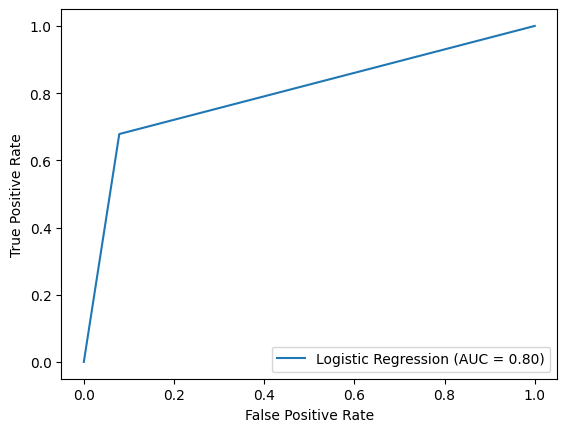

In [26]:
data['gender'].replace({'Female' : 1, 'Male' : 0}, inplace=True)

# Splitting the dataset into training and test sets
train = data.sample(frac=0.7, random_state=10)  # 70% for training
test = data.drop(train.index)  # Remaining data for testing

# Feature engineering and preprocessing on the training set
X_train, Y_train, country_transformer, ethnicity_transformer, relation_transformer, imputer, st_x = fit_transform(train)

# Preprocess and transform the test set
X_test = transform(test, country_transformer, ethnicity_transformer, relation_transformer, imputer, st_x)
Y_test = test['Class/ASD'].to_numpy()

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()


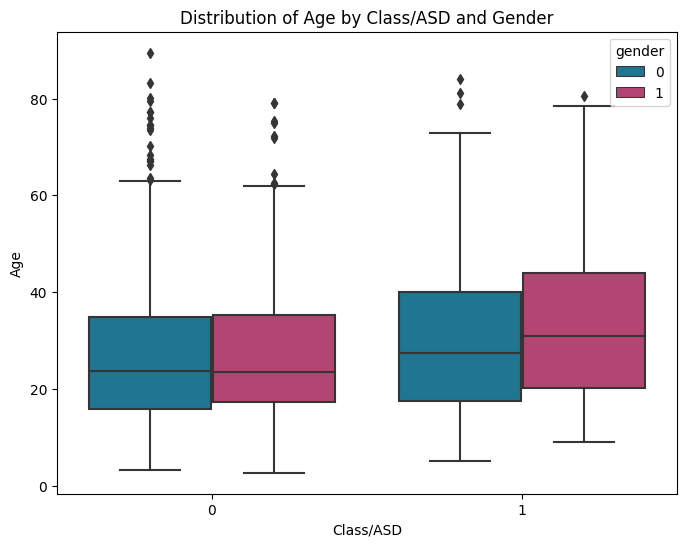

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = ['#0d7fa3','#c4336d']

# Create the boxplot with the custom color palette
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Class/ASD', y='age', hue='gender', palette=custom_palette)

# Set labels and title
plt.xlabel('Class/ASD')
plt.ylabel('Age')
plt.title('Distribution of Age by Class/ASD and Gender')

# Show the plot
plt.show()

# the effect of age on ASD may vary depending on the gender of the individual,
#here we can observe a subtle difference in the distribution when gender is taken into account.



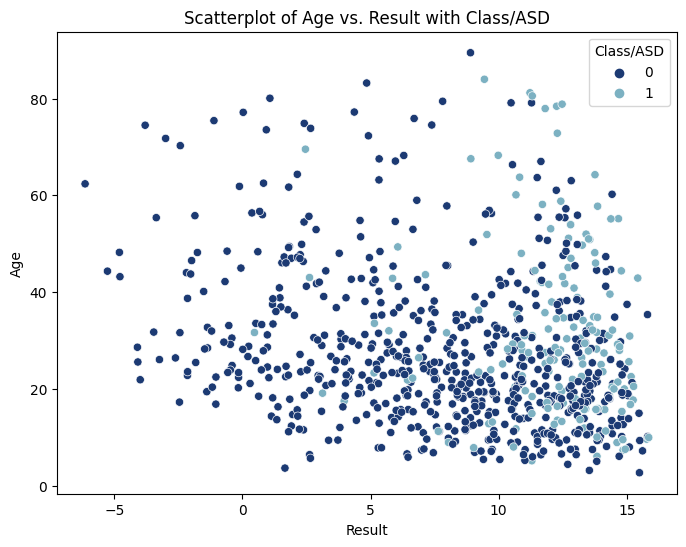

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = ['#1c3a73', '#7cb1c2']

# Create the scatterplot with the custom color palette
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x='result', y='age', hue='Class/ASD', palette=custom_palette)

# Set labels and title
plt.xlabel('Result')
plt.ylabel('Age')
plt.title('Scatterplot of Age vs. Result with Class/ASD')

# Show the plot
plt.show()

In [29]:
# Create interaction features by multiplying 'gender' and 'age' in the training and test sets
train['gender_cross_age'] = train['gender'] * train['age']
test['gender_cross_age'] = test['gender'] * test['age']

# Create interaction features by multiplying 'age' and 'result' in the training and test sets
train['age_cross_result'] = train['age'] * train['result']
test['age_cross_result'] = test['age'] * test['result']

======== train ==========
AUC :  0.7913560111835973
Accuracy :  0.8660714285714286
Confusion Matrix:
[[408  36]
 [ 39  77]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       444
           1       0.68      0.66      0.67       116

    accuracy                           0.87       560
   macro avg       0.80      0.79      0.79       560
weighted avg       0.86      0.87      0.87       560

======== test ==========
AUC :  0.812111801242236
Accuracy :  0.8833333333333333
Confusion Matrix:
[[174  10]
 [ 18  38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       184
           1       0.79      0.68      0.73        56

    accuracy                           0.88       240
   macro avg       0.85      0.81      0.83       240
weighted avg       0.88      0.88      0.88       240



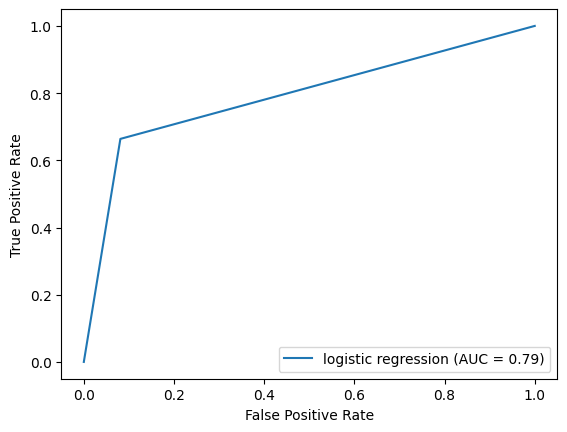

In [30]:
X_train, Y_train, country_transofrmer, ethnicity_transformer, relation_transformer, imputer, st_x = fit_transform(train)
X_test = transform(test, country_transofrmer, ethnicity_transformer, relation_transformer, imputer, st_x)
Y_test = test['Class/ASD'].to_numpy()


model = LogisticRegression()
model.fit(X_train, Y_train)


y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train)

print('======== train ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

print('======== test ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='logistic regression')
display.plot()

<Axes: >

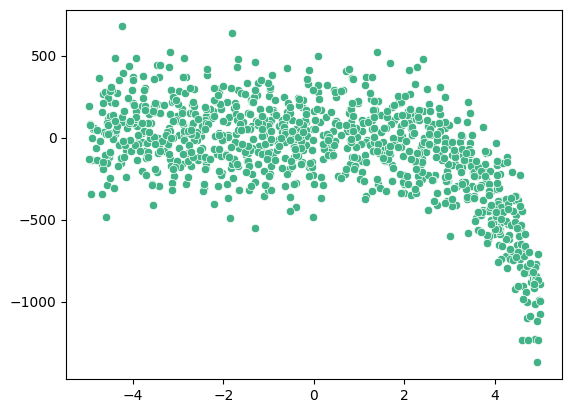

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns

# Number of samples
n = 1000

# Generate random x values from a uniform distribution between -5 and 5
x = np.random.uniform(-5, 5, n)

# Create a polynomial function of x with added Gaussian noise
y = 10 * x + 5 * x**2 - 4 * x**3 - x**4 + 3 + np.random.normal(0, 200, n)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(x=x, y=y, color='#42b387')


In [32]:
# Import necessary libraries for linear regression and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train = X_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)

# Define a function to run k-fold cross-validation for linear regression
def run_kfold_regression(data_x, data_y, k):
    mean_train_loss = 0
    mean_validation_loss = 0

    kfold = KFold(n_splits=k, shuffle=True)
    for train_indexes, validation_indexes in kfold.split(data_x):
        k_fold_train_x = data_x[train_indexes]
        k_fold_train_y = data_y[train_indexes]
        validation_x = data_x[validation_indexes]
        validation_y = data_y[validation_indexes]

        model = LinearRegression()
        model.fit(k_fold_train_x, k_fold_train_y)

        train_y_hat = model.predict(k_fold_train_x)
        train_mse = mean_squared_error(k_fold_train_y, train_y_hat)
        mean_train_loss += train_mse

        validation_y_hat = model.predict(validation_x)
        validation_mse = mean_squared_error(validation_y, validation_y_hat)
        mean_validation_loss += validation_mse

    mean_train_loss /= k
    mean_validation_loss /= k

    return mean_train_loss, mean_validation_loss

# Initialize lists to store model complexity, train loss, and validation loss
model_complexity_list = []
train_loss_list = []
validation_loss_list = []

# Loop over different model complexities
for model_complexity in range(1, 20):
    data_x = np.hstack([X_train**i for i in range(1, model_complexity+1)])
    data_y = y_train

    # Run k-fold cross-validation and compute train and validation losses
    train_loss, validation_loss = run_kfold_regression(data_x, data_y, 20)

    model_complexity_list.append(model_complexity)
    train_loss_list.append(train_loss)
    validation_loss_list.append(validation_loss)

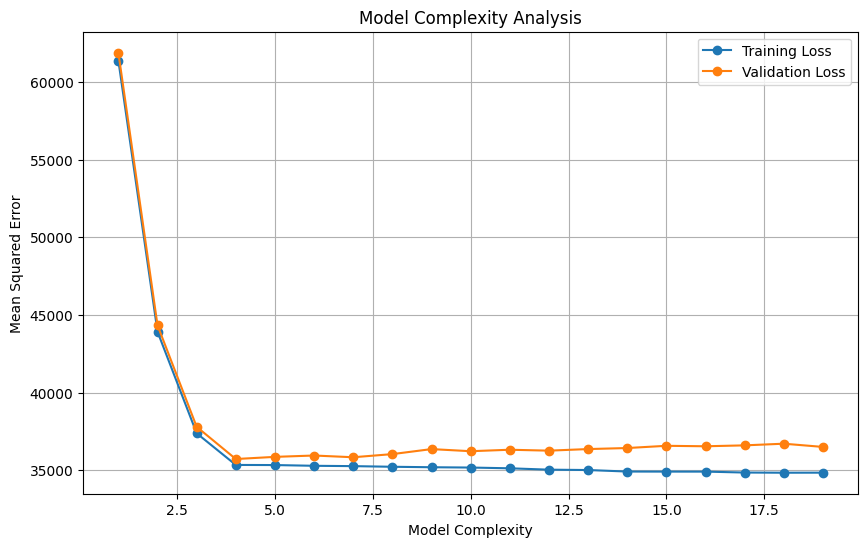

In [33]:
import matplotlib.pyplot as plt


# Plot the training and validation losses against model complexity
plt.figure(figsize=(10, 6))
plt.plot(model_complexity_list, train_loss_list, label='Training Loss', marker='o')
plt.plot(model_complexity_list, validation_loss_list, label='Validation Loss', marker='o')

plt.title('Model Complexity Analysis')
plt.xlabel('Model Complexity')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)

plt.show()


<Axes: xlabel='complexity', ylabel='loss'>

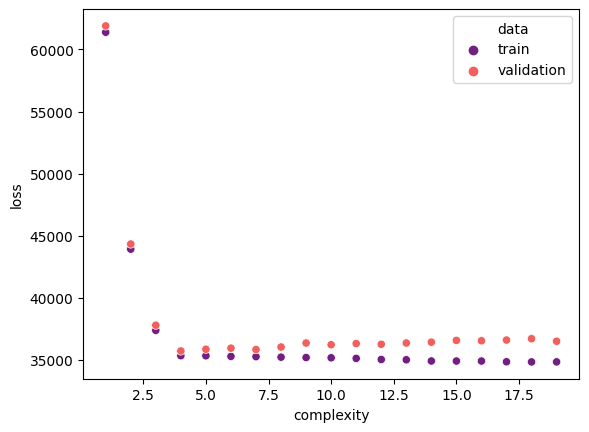

In [34]:
# Import necessary libraries
import pandas as pd
import seaborn as sns

# Create validation data combining training and validation metrics
validation_data = {
    'complexity': model_complexity_list + model_complexity_list,
    'loss': train_loss_list + validation_loss_list,
    'data': ['train'] * len(train_loss_list) + ['validation'] * len(train_loss_list)
}

# Create a DataFrame from the validation data
validation_df = pd.DataFrame(validation_data)

# Create a scatterplot with seaborn, changing the color scheme
sns.scatterplot(data=validation_df, x='complexity', y='loss', hue='data', palette='magma')


In [35]:
# Import necessary libraries for feature selection and logistic regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Split the data into training and testing sets
train = data.sample(frac=0.7, random_state=10)
test = data.drop(train.index)

# Preprocess and transform the training and test sets
X_train, Y_train, country_transofrmer, ethnicity_transformer, relation_transformer, imputer, st_x = fit_transform(train)
X_test = transform(test, country_transofrmer, ethnicity_transformer, relation_transformer, imputer, st_x)
Y_test = test['Class/ASD'].to_numpy()

# Initialize a Logistic Regression model
model = LogisticRegression()

# Define a StratifiedKFold cross-validation
cv = StratifiedKFold(3)

# Initialize Recursive Feature Elimination with Cross-Validation (RFECV)
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring='roc_auc',  # Specify the scoring metric (ROC AUC in this case)
    min_features_to_select=1,
)
rfecv.fit(X_train, Y_train)

# Print the optimal number of selected features
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 9


In [36]:
# which columns used and which wasn't
rfecv.support_

array([False,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True, False, False, False, False, False, False,  True,
       False])

In [37]:
# Access the selected features' indices
selected_feature_indices = np.where(rfecv.support_)[0]

# Get the names of the selected features
selected_feature_names = X_train.columns[selected_feature_indices]


AttributeError: ignored

In [38]:
# features ranking low is better
rfecv.ranking_

array([ 9,  1,  1,  1,  2,  1,  1,  1,  1,  3,  1, 10,  4, 11,  6,  7,  8,
        1,  5])

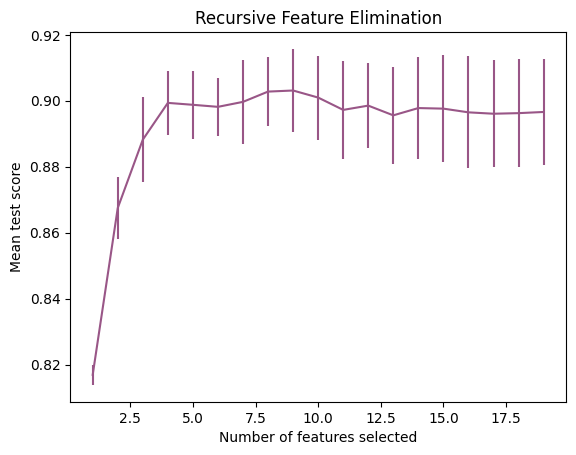

In [39]:
# Calculate the number of different feature selections tested
n_scores = len(rfecv.cv_results_["mean_test_score"])

# Create a new figure for plotting
plt.figure()

# Set labels for the x and y axes
plt.xlabel("Number of features selected")
plt.ylabel("Mean test score")

# Plot the mean test scores with error bars
plt.errorbar(
    range(1, n_scores + 1),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
    color='#995687'  # Change the color to green
)

# Set the title for the plot
plt.title("Recursive Feature Elimination")

# Show the plot
plt.show()

======== Training Set ==========
AUC :  0.7998045920859795
Accuracy :  0.8714285714285714
Confusion Matrix:
[[410  35]
 [ 37  78]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       445
           1       0.69      0.68      0.68       115

    accuracy                           0.87       560
   macro avg       0.80      0.80      0.80       560
weighted avg       0.87      0.87      0.87       560

======== Test Set ==========
AUC :  0.7944095889128197
Accuracy :  0.8708333333333333
Confusion Matrix:
[[171  10]
 [ 21  38]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.94      0.92       181
           1       0.79      0.64      0.71        59

    accuracy                           0.87       240
   macro avg       0.84      0.79      0.81       240
weighted avg       0.87      0.87      0.87       240



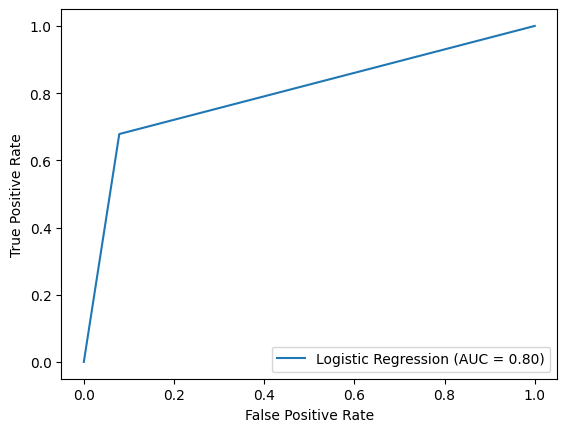

In [40]:
# Preprocess and transform the training and test sets using the fit_transform and transform functions
X_train, Y_train, country_transofrmer, ethnicity_transformer, relation_transformer, imputer, st_x = fit_transform(train)
X_test = transform(test, country_transofrmer, ethnicity_transformer, relation_transformer, imputer, st_x)
Y_test = test['Class/ASD'].to_numpy()

# Select only the features that were chosen by RFECV
X_train = X_train[:, rfecv.support_]
X_test = X_test[:, rfecv.support_]

# Initialize and train a Logistic Regression model
model = LogisticRegression()
model.fit(X_train, Y_train)

# Make predictions on the test and training sets
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# Calculate evaluation metrics and scores for the test and training sets
conf_matrix_test, class_report_test, auc_test, acc_test = get_scores(y_pred_test, Y_test)
conf_matrix_train, class_report_train, auc_train, acc_train = get_scores(y_pred_train, Y_train)

# Print scores and evaluation metrics for the training set
print('======== Training Set ==========')
print_scores(conf_matrix_train, class_report_train, auc_train, acc_train)

# Print scores and evaluation metrics for the test set
print('======== Test Set ==========')
print_scores(conf_matrix_test, class_report_test, auc_test, acc_test)

# Plot the ROC curve for the training set
fpr, tpr, thresholds = roc_curve(y_pred_train, Y_train)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()